# UKB24983 v2 release (488k dataset) include/exclude criteria

## Yosuke Tanigawa (ytanigaw@stanford.edu) on 2017/7/30

- We will remove 151k individuals that match any of the following criteria.
  1. `in_white_British_ancestry_subset == 0`
  1. `used_in_pca_calculation == 0`
  1. `het_missing_outliers == 1`
  1. `excess_relatives == 1`
  1. `putative_sex_chromosome_aneuploidy == 1`
- Note: we didn't use the following field
  - `in_kinship_table` 
- The detailed description of these fileds are documented here:
  - http://biobank.ndph.ox.ac.uk/showcase/refer.cgi?id=531
- The resulting `.phe` file can be used with `--remove` option of PLINK

In [1]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it

# plot

font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

# read related files
- Read the following two files
  1. fam file (application 24983)
  1. sample quality control (sqc) file

In [2]:
def check_df(df):
    """Show the shape and first 5 entries of a given pandas data frame"""
    print('shape of this data frame is {}'.format(df.shape))
    return df.head()

In [3]:
fam_f = '/scratch/PI/mrivas/ukbb/24983/fam_24983/ukb2498_cal_v2_s488370.fam'
sqc_f_names_f = './ukb_sqc_v2.fields.txt'
sqc_f = '/scratch/PI/mrivas/ukbb/24983/sqc/ukb_sqc_v2.txt'

### fam file

In [4]:
fam_df = pd.read_csv(
    fam_f, sep='\s+',
    names=['FID', 'IID', 'father', 'mother', 'sex', 'batch']
)

In [5]:
check_df(fam_df)

shape of this data frame is (488377, 6)


,FID,IID,father,mother,sex,batch
0,2502845,2502845,0,0,1,Batch_b001
1,2314965,2314965,0,0,2,Batch_b001
2,1142584,1142584,0,0,2,Batch_b001
3,3665122,3665122,0,0,2,Batch_b001
4,4377492,4377492,0,0,2,Batch_b001


### sample quality control file (sqc)

In [6]:
with open(sqc_f_names_f, 'r') as f:
    sqc_f_names = [x.rstrip() for x in f.readlines() if len(x) > 1]
sqc_df = pd.read_csv(sqc_f, sep='\s+', names = sqc_f_names)

In [7]:
check_df(sqc_df)

shape of this data frame is (488377, 89)


,affymetrix_field_1,affymetrix_field_2,genotyping_array,Batch,Plate_Name,Well,Cluster_CR,dQC,Internal_Pico_ng_uL,Submitted_Gender,...,in_Phasing_Input_chr15,in_Phasing_Input_chr16,in_Phasing_Input_chr17,in_Phasing_Input_chr18,in_Phasing_Input_chr19,in_Phasing_Input_chr20,in_Phasing_Input_chr21,in_Phasing_Input_chr22,in_Phasing_Input_chrX,in_Phasing_Input_chrXY
0,A550484-4214737-041115-493_A01,2032476,UKBB,Batch_b001,SMP4_0012258,A01,99.245,0.96,33.11,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A550484-4214737-041115-493_A02,2868665,UKBB,Batch_b001,SMP4_0012258,A02,99.634,0.97,30.32,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A550484-4214737-041115-493_A03,5580157,UKBB,Batch_b001,SMP4_0012258,A03,99.721,0.98,38.97,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A550484-4214737-041115-493_A04,5184402,UKBB,Batch_b001,SMP4_0012258,A04,99.742,0.98,39.13,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A550484-4214737-041115-493_A05,1114375,UKBB,Batch_b001,SMP4_0012258,A05,99.631,0.98,48.28,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# sampleqc.filter
- We will simply count the number of individuals for QC flags of our interest

In [8]:
def dump_numbers(sqc_df, column):
    """Given a sqc data frame and a name of the column of interest, 
       This function can show the count of 0/1"""
    print(column)
    print('range of this QC is {} and {} individuals have 1 and {} have 0'.format(
        str(set(sqc_df[column])), 
        sqc_df[column].sum(),
        len(sqc_df) - sqc_df[column].sum()
    ))

## 1) in_white_British_ancestry_subset (want to remove 0)

In [9]:
dump_numbers(sqc_df, 'in_white_British_ancestry_subset')

in_white_British_ancestry_subset
range of this QC is {0, 1} and 409703 individuals have 1 and 78674 have 0


- We will provide a brief PCA analysis at the end of this notebook

## 2) used_in_pca_calculation (want to exclude 0)

In [10]:
dump_numbers(sqc_df, 'used_in_pca_calculation')

used_in_pca_calculation
range of this QC is {0, 1} and 407219 individuals have 1 and 81158 have 0


## 3) het_missing_outliers (want to remove 1)

In [11]:
dump_numbers(sqc_df, 'het_missing_outliers')

het_missing_outliers
range of this QC is {0, 1} and 968 individuals have 1 and 487409 have 0


## 4) excess_relatives (want to remove 1)

In [12]:
dump_numbers(sqc_df, 'excess_relatives')

excess_relatives
range of this QC is {0, 1} and 188 individuals have 1 and 488189 have 0


## 5) putative_sex_chromosome_aneuploidy (want to remove 1)

In [13]:
dump_numbers(sqc_df, 'putative_sex_chromosome_aneuploidy')

putative_sex_chromosome_aneuploidy
range of this QC is {0, 1} and 652 individuals have 1 and 487725 have 0


## [we didn't use this filed] in_kinship_table (want to remove 1)

In [14]:
dump_numbers(sqc_df, 'in_kinship_table')

in_kinship_table
range of this QC is {0, 1} and 147731 individuals have 1 and 340646 have 0


- We didn't use this field for the sake of the remaining sample size after filteration.

## Create a list of individuals that hit our exclusion criteria

In [15]:
sampleqc_df = fam_df[['FID', 'IID']][(sqc_df.in_white_British_ancestry_subset == 0) |
                                     (sqc_df.used_in_pca_calculation == 0) |
                                     (sqc_df.het_missing_outliers == 1) |
                                     (sqc_df.excess_relatives == 1) |
                                     (sqc_df.putative_sex_chromosome_aneuploidy == 1)]

In [16]:
print(
    ' The total sample size is {}\n'.format(sqc_df.shape[0]),
    'The number of sample we are removing is {}\n'.format(sampleqc_df.shape[0]),
    'The remaining sample size is {}\n'.format(sqc_df.shape[0] - sampleqc_df.shape[0]),
)

 The total sample size is 488377
 The number of sample we are removing is 151169
 The remaining sample size is 337208



## write to a `.phe` file

In [17]:
sampleqc_df.head()

,FID,IID
5,2652670,2652670
16,2850227,2850227
18,3946352,3946352
25,3073546,3073546
31,2063443,2063443


In [18]:
sampleqc_df[
    ['FID', 'IID']
].to_csv(
    '/scratch/PI/mrivas/ukbb/24983/phe/ukb24983_remove.phe', 
    sep='\t', index=False, header=False
)

# Verify `in_white_British_ancestry_subset` flag with PCA plots
- In this section, we will plot PCs for both `in_white_British_ancestry_subset == 0` and `in_white_British_ancestry_subset == 1`

In [19]:
not_in_white_British = sqc_df[sqc_df.in_white_British_ancestry_subset == 0]
in_white_British     = sqc_df[sqc_df.in_white_British_ancestry_subset == 1]

In [20]:
print(
    ' not_in_white_British has {} samples\n'.format(len(not_in_white_British)),
    'in_white_British has {} samples'.format(len(in_white_British))
)

 not_in_white_British has 78674 samples
 in_white_British has 409703 samples


## `in_white_British_ancestry_subset == 0`

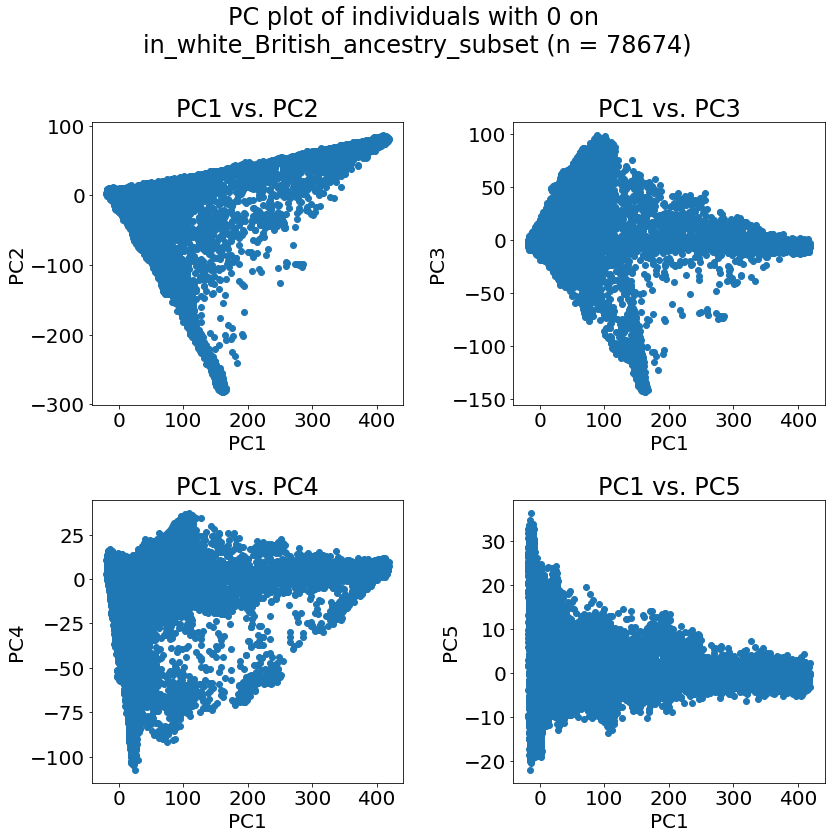

In [21]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(ss) for ss in gs]

for axsidx in range(len(axs)):
    axs[axsidx].plot(not_in_white_British['PC1'], 
                     not_in_white_British['PC{}'.format(axsidx + 2)], 'o')
    axs[axsidx].set_xlabel('PC1')
    axs[axsidx].set_ylabel('PC{}'.format(axsidx + 2))
    axs[axsidx].set_title('PC1 vs. PC{}'.format(axsidx + 2))
    
fig.suptitle(
    'PC plot of individuals with 0 on \nin_white_British_ancestry_subset (n = {})'.format(
        not_in_white_British.shape[0])
)
gs.tight_layout(fig, rect=[0, 0, 1, .9])
gs.tight_layout(fig, rect=[0, 0, 1, .9])
# fig.savefig('./pca_in_white_British.png')

## `in_white_British_ancestry_subset == 1`

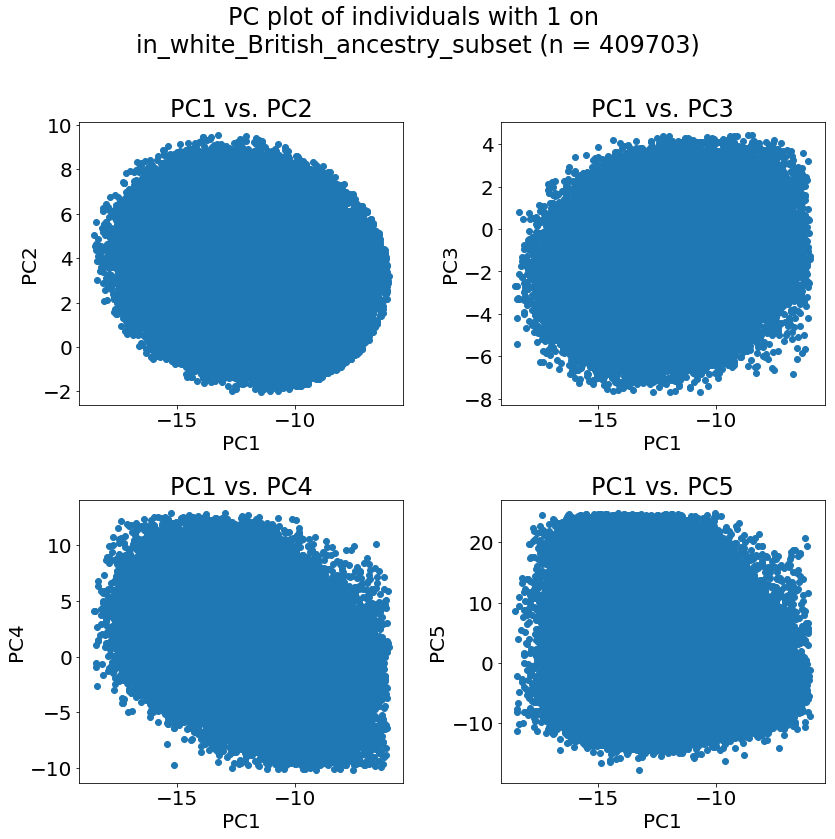

In [22]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(ss) for ss in gs]

for axsidx in range(len(axs)):
    axs[axsidx].plot(in_white_British['PC1'], 
                     in_white_British['PC{}'.format(axsidx + 2)], 'o')
    axs[axsidx].set_xlabel('PC1')
    axs[axsidx].set_ylabel('PC{}'.format(axsidx + 2))
    axs[axsidx].set_title('PC1 vs. PC{}'.format(axsidx + 2))
    
fig.suptitle(
    'PC plot of individuals with 1 on \nin_white_British_ancestry_subset (n = {})'.format(
        in_white_British.shape[0])
)
gs.tight_layout(fig, rect=[0, 0, 1, .9])
# fig.savefig('./pca_in_white_British.png')